# Convolutional Neural Networks

## Project: Write an Algorithm for Landmark Classification



In this project, I apply the skills I have acquired in the Convolutional Neural Network (CNN) course to build a landmark classifier.

Photo sharing and photo storage services like to have location data for each photo that is uploaded. With the location data, these services can build advanced features, such as automatic suggestion of relevant tags or automatic photo organization, which help provide a compelling user experience. Although a photo's location can often be obtained by looking at the photo's metadata, many photos uploaded to these services will not have location metadata available. This can happen when, for example, the camera capturing the picture does not have GPS or if a photo's metadata is scrubbed due to privacy concerns.

If no location metadata for an image is available, one way to infer the location is to detect and classify a discernible landmark in the image. Given the large number of landmarks across the world and the immense volume of images that are uploaded to photo sharing services, using human judgment to classify these landmarks would not be feasible.

In this project, I take the first steps towards addressing this problem by building models to automatically predict the location of the image based on any landmarks depicted in the image. I went through the machine learning design process end-to-end: performing data preprocessing, designing and training CNNs, comparing the accuracy of different CNNs, and deploying an app based on the best CNN that I trained.

<div><img src="static_images/train/bridge1.jpg" alt=" Bridge in Brooklyn" style="width: 300px;height:300px;"/>
<img src="static_images/train/eiffen2.jpg" alt="Eiffel Tower in Paris, France" style="width: 300px;height:300px;"/>
<img src="static_images/train/viena3.jpg" alt="City Hall in Vienna" style="width: 300px;height:300px;"/>
<p>Examples from the landmarks dataset - the Brooklyn Bridge, the Eiffel Tower and Vienna City Hall</p>

</div>


Project Steps

The high level steps of the project include:

* Create a CNN to Classify Landmarks (from Scratch) - Here, I  will visualize the dataset, process it for training, and then build a convolutional neural network from scratch to classify the landmarks. I also describe some of my decisions around data processing and how I chose my network architecture. I then export my best network using Torch Script.

*  Create a CNN to Classify Landmarks (using Transfer Learning) - Next, I will investigate different pre-trained models and decide on one to use for this classification task. Along with training and testing this transfer-learned network, I'll explain how I will arrived at the pre-trained network I chose. I will also export my best transfer learning solution using Torch Script

* Deploy the algorithm in an app - Finally, I will use my best model to create a simple app for others to be able to use my model to find the most likely landmarks depicted in an image. I'll also test out my model myself and reflect on the strengths and weaknesses of my model.

Each of these three major steps is carried out in a corresponding Jupyter Notebook, So there are three notebooks for these project work.


The project folder has the following structure:

* In the main directory I have this notebook, `cnn_from_scratch.ipynb`, that contains CNN to Classify Landmarks (from Scratch)

* In the `src/` directory I have several source files. As instructed in this notebook. 



## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 0: Setting up

The following cells make sure that your environment is setup correctly, download the data if you don't have it already, and also check that your GPU is available and ready to go. You have to execute them every time you restart your notebook.

In [ ]:
# Install requirements
!pip install -r requirements.txt | grep -v "already satisfied"

In [1]:
from src.helpers import setup_env

# If running locally, this will download dataset (make sure you have at 
# least 2 Gb of space on your hard drive)
setup_env()

GPU available
Dataset already downloaded. If you need to re-download, please delete the directory landmark_images
Reusing cached mean and std


In [2]:
import torch
torch.cuda.empty_cache()

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 1: Data

In this and the following steps we are going to  execute some tests to make sure the code works as intended. 

Open the file `src/data.py`. It contains a function called `get_data_loaders`.  I used Pytest to test that my implementation is correct by executing the following cell:

In [3]:
!pytest -vv src/data.py -k data_loaders

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-7.2.1, pluggy-1.0.0 -- /home/kach271771/Desktop/pythonenvs/landmark_udacity/bin/python
cachedir: .pytest_cache
rootdir: /media/kach271771/LocalDisk/Research/06_Trainings/Landmark-classifier
plugins: anyio-3.6.2
collected 4 items / 1 deselected / 3 selected                                  

src/data.py::test_data_loaders_keys PASSED                               [ 33%]
src/data.py::test_data_loaders_output_type PASSED                        [ 66%]
src/data.py::test_data_loaders_output_shape PASSED                       [100%]

======================= 3 passed, 1 deselected in 1.07s ========================


<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question:** Describe your chosen procedure for preprocessing the data. 
- How does your code resize the images (by cropping, stretching, etc)?  What size did you pick for the input tensor, and why?
- Did you decide to augment the dataset?  If so, how (through translations, flips, rotations, etc)?  If not, why not?

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> **Answer**: 
1. The image has been resized to 256 and a crop of 224 has been set as 224x224 is the recommended input size from many literatures for using pytorch's pre-trained models. 
2. This medium article (https://medium.datadriveninvestor.com/why-randaugment-is-the-best-data-augmentation-approach-4a48f22b2152) motivated me to choose RandAugment with RandomHorizontalFlip.

### Visualize a Batch of Training Data

Go back to `src/data.py` and I have a function `visualize_one_batch`  we execute the following cell and make sure the test `src/data.py::test_visualize_one_batch` is `PASSED`:

In [4]:
!pytest -vv src/data.py -k visualize_one_batch

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-7.2.1, pluggy-1.0.0 -- /home/kach271771/Desktop/pythonenvs/landmark_udacity/bin/python
cachedir: .pytest_cache
rootdir: /media/kach271771/LocalDisk/Research/06_Trainings/Landmark-classifier
plugins: anyio-3.6.2
collected 4 items / 3 deselected / 1 selected                                  

src/data.py::test_visualize_one_batch PASSED                             [100%]

======================= 1 passed, 3 deselected in 1.31s ========================


Next we get a batch of images from the train data loader and look at them.

Visualizing the output of our data loader is a great way to ensure that our data loading and preprocessing (including transforms such as rotations, translations, color transforms...) are working as expected.

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


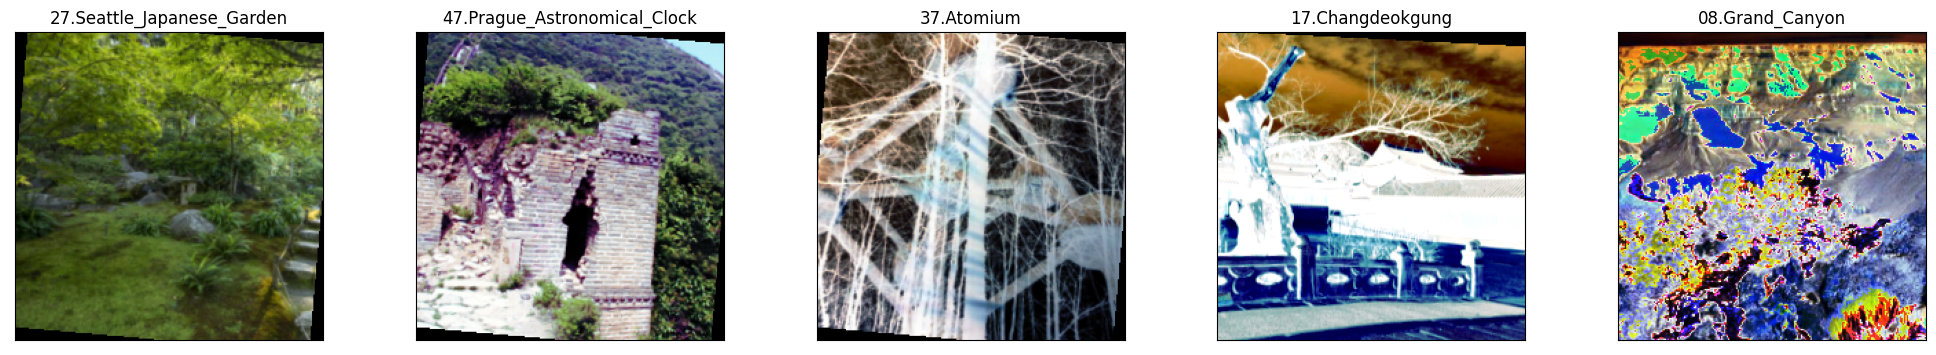

In [5]:
%matplotlib inline
from src.data import visualize_one_batch, get_data_loaders

# use get_data_loaders to get the data_loaders dictionary. Use a batch_size
# of 5, a validation size of 0.01 and num_workers=-1 (all CPUs)
data_loaders = get_data_loaders(5,0.01)

visualize_one_batch(data_loaders)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 2: Define model

Open `src/model.py` we have  `MyModel` class which contains the CNN architectures used,  execute the following test and make sure it passes:

In [8]:
!pytest -vv src/model.py/home/kach271771/Desktop/pythonenvs/radial/bin/python3.8

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-7.2.1, pluggy-1.0.0 -- /home/kach271771/Desktop/pythonenvs/landmark_udacity/bin/python
cachedir: .pytest_cache
rootdir: /media/kach271771/LocalDisk/Research/06_Trainings/Landmark-classifier
plugins: anyio-3.6.2
collected 1 item                                                               

src/model.py::test_model_construction PASSED                             [100%]

============================== 1 passed in 1.61s ===============================


<img src="static_images/icons/noun-question-mark-869751.png" alt="?" style="width:25px"/> **Question**: Outline the steps you took to get to your final CNN architecture and your reasoning at each step.  

<img src="static_images/icons/noun-answer-3361020.png" alt=">" style="width:25px"/> __Answer:__ 
1. Five convolutional layers have been used so that the model could sufficiently be vivid. 
2. Dropout layers have been even used to reduce overfitting. 
3. Of course, the output is a 50-dimensional vector to match with the 50 landmark classes.

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 3: define loss and optimizer

Open `src/optimization.py` and we have the `get_loss` function, we execute the test and make sure it passes:

In [10]:
!pytest -vv src/optimization.py -k get_loss

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-7.2.1, pluggy-1.0.0 -- /home/kach271771/Desktop/pythonenvs/landmark_udacity/bin/python
cachedir: .pytest_cache
rootdir: /media/kach271771/LocalDisk/Research/06_Trainings/Landmark-classifier
plugins: anyio-3.6.2
collected 7 items / 6 deselected / 1 selected                                  

src/optimization.py::test_get_loss PASSED                                [100%]

======================= 1 passed, 6 deselected in 1.18s ========================


Then, in the same file, we have the `get_optimizer` function we then execute its tests, and make sure they all pass:

In [11]:
!pytest -vv src/optimization.py -k get_optimizer

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-7.2.1, pluggy-1.0.0 -- /home/kach271771/Desktop/pythonenvs/landmark_udacity/bin/python
cachedir: .pytest_cache
rootdir: /media/kach271771/LocalDisk/Research/06_Trainings/Landmark-classifier
plugins: anyio-3.6.2
collected 7 items / 1 deselected / 6 selected                                  

src/optimization.py::test_get_optimizer_type PASSED                      [ 16%]
src/optimization.py::test_get_optimizer_is_linked_with_model PASSED      [ 33%]
src/optimization.py::test_get_optimizer_returns_adam PASSED              [ 50%]
src/optimization.py::test_get_optimizer_sets_learning_rate PASSED        [ 66%]
src/optimization.py::test_get_optimizer_sets_momentum PASSED             [ 83%]
src/optimization.py::test_get_optimizer_sets_weight_decat PASSED         [100%]

======================= 6 passed, 1 deselected in 1.18s ========================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 4: Train and Validate the Model

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/> Testing ML code is notoriously difficult. The tests in this section merely exercise the functions we have in our python script, so it will help us catch glaring problems but it won't guarantee that our training code is bug-free. If we see that our loss is not decreasing, for example, that's a sign of a bug or of a flawed model design. we have to use our judgement.

Open `src/train.py` and we have the `train_one_epoch` function, then run the tests:

In [12]:
!pytest -vv src/train.py -k train_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-7.2.1, pluggy-1.0.0 -- /home/kach271771/Desktop/pythonenvs/landmark_udacity/bin/python
cachedir: .pytest_cache
rootdir: /media/kach271771/LocalDisk/Research/06_Trainings/Landmark-classifier
plugins: anyio-3.6.2
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_train_one_epoch PASSED                                [100%]

======================= 1 passed, 3 deselected in 6.27s ========================


Now still in the same Python file, we have the `valid` function, let's run the tests:

In [13]:
!pytest -vv src/train.py -k valid_one_epoch

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-7.2.1, pluggy-1.0.0 -- /home/kach271771/Desktop/pythonenvs/landmark_udacity/bin/python
cachedir: .pytest_cache
rootdir: /media/kach271771/LocalDisk/Research/06_Trainings/Landmark-classifier
plugins: anyio-3.6.2
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_valid_one_epoch PASSED                                [100%]

======================= 1 passed, 3 deselected in 6.20s ========================


Now we then run the tests of the `optimize` function in the same file:

In [14]:
!pytest -vv src/train.py -k optimize

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-7.2.1, pluggy-1.0.0 -- /home/kach271771/Desktop/pythonenvs/landmark_udacity/bin/python
cachedir: .pytest_cache
rootdir: /media/kach271771/LocalDisk/Research/06_Trainings/Landmark-classifier
plugins: anyio-3.6.2
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_optimize PASSED                                       [100%]

======================= 1 passed, 3 deselected in 8.01s ========================


Finally, then run the tests on the `test` function:

In [15]:
!pytest -vv src/train.py -k one_epoch_test

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-7.2.1, pluggy-1.0.0 -- /home/kach271771/Desktop/pythonenvs/landmark_udacity/bin/python
cachedir: .pytest_cache
rootdir: /media/kach271771/LocalDisk/Research/06_Trainings/Landmark-classifier
plugins: anyio-3.6.2
collected 4 items / 3 deselected / 1 selected                                  

src/train.py::test_one_epoch_test PASSED                                 [100%]

======================= 1 passed, 3 deselected in 15.17s =======================


---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 5: Putting everything together

Allright, good job getting here! Now it's time to see if all our hard work pays off. In the following cell we will train our model and validate it against the validation set.

Let's start by defining a few hyperparameters. We will try to experiment with different values and try to optimize our model:

In [16]:
batch_size = 32        # size of the minibatch for stochastic gradient descent (or Adam)
valid_size = 0.2       # fraction of the training data to reserve for validation
num_epochs = 100     # number of epochs for training
num_classes = 50      # number of classes. Do not change this
dropout = 0.5         # dropout for our model
learning_rate = 0.001  # Learning rate for SGD (or Adam)
opt = 'adam'            # optimizer. 'sgd' or 'adam'
weight_decay = 0.0   # regularization. Increase this to combat overfitting

### Learning  rate finder

We want to find a range for the learning rate that make sense 

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])


Training:  99%|██████████████████████████████▊| 124/125 [00:19<00:00,  6.27it/s]


(4.060306793526758, 4.691722534641214)

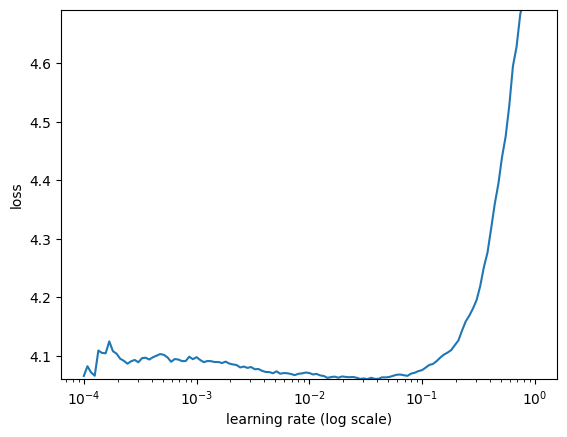

In [17]:
from src.data import get_data_loaders
from src.train import optimize
from src.optimization import get_optimizer, get_loss
from src.model import MyModel
from src.lr_finder import lr_finder
import matplotlib.pyplot as plt
import numpy as np


# get the data loaders using batch_size and valid_size defined in the previous
# cell
# HINT: do NOT copy/paste the values. Use the variables instead
data_loaders = get_data_loaders(batch_size,valid_size)

# instance model MyModel with num_classes and drouput defined in the previous
# cell
model = MyModel(num_classes,dropout)

# Get the optimizer using get_optimizer and the model you just created, the learning rate,
# the optimizer and the weight decay specified in the previous cell
optimizer = get_optimizer(model,opt,learning_rate,weight_decay)

# Get the loss using get_loss
loss = get_loss()



# range and number of steps for learnong rate
min_lr = 0.0001
max_lr = 1
n_steps = min(len(data_loaders["train"]), 200)

losses = lr_finder(min_lr, max_lr, n_steps, loss, model.cuda(), data_loaders)
# Plot the results 
plt.plot(losses.keys(), losses.values())
plt.xscale("log")
plt.ylabel("loss")
plt.xlabel("learning rate (log scale)")

# Adjust the range on the y-axis to see things more clearly
plt.ylim([min(losses.values()), np.percentile(list(losses.values()), 97)])

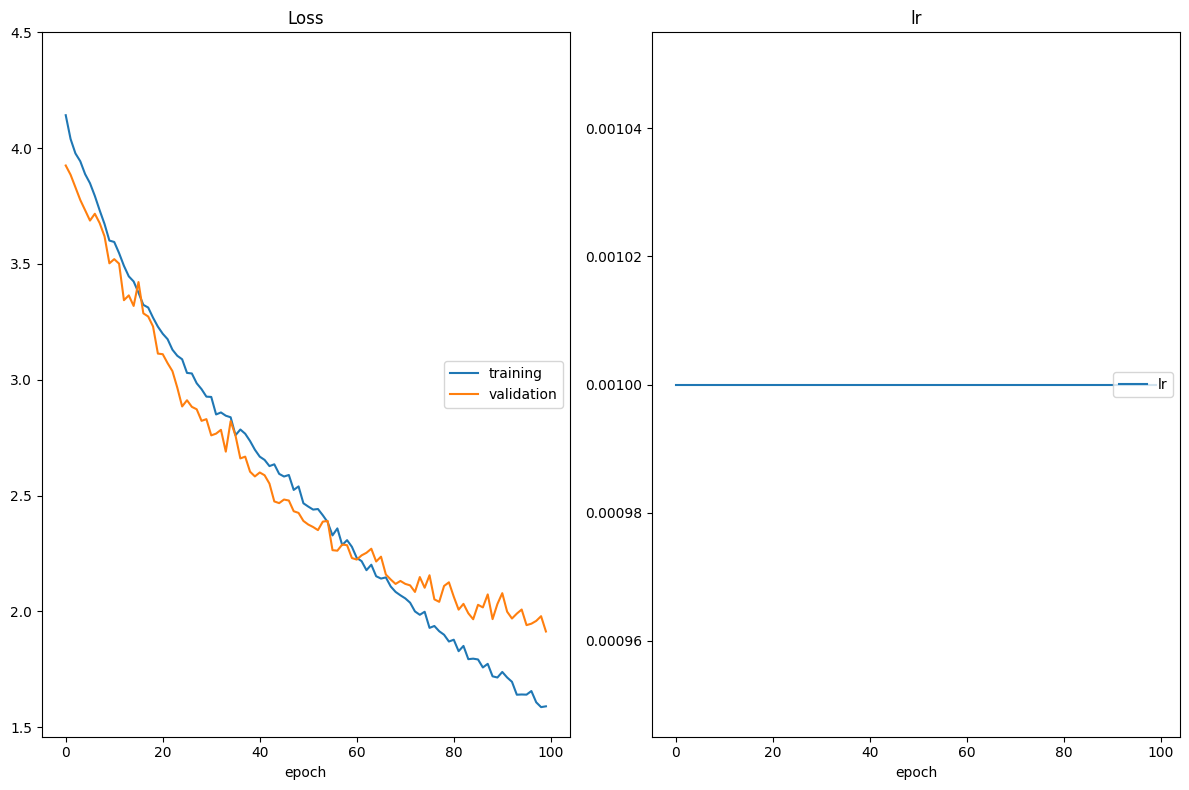

In [18]:
optimize(
    data_loaders,
    model,
    optimizer,
    loss,
    n_epochs=num_epochs,
    save_path="checkpoints/best_val_loss.pt",
    interactive_tracking=True
)

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 6: testing against the Test Set

> <img src="static_images/icons/noun-info-2558213.png" alt="?" style="width:25px"/>  Let's run this *after* since we have have completed hyperpameter optimization. We do not optimize hyperparameters by looking at the results on the test set so that we don't overfit on the test set which is (bad, bad, bad)

Let's run the code cell below to try out our model on the test dataset of landmark images.

In [19]:
# load the model that got the best validation accuracy
from src.train import one_epoch_test
from src.model import MyModel
import torch

model = MyModel(num_classes=num_classes, dropout=dropout)

# YOUR CODE HERE: load the weights in 'checkpoints/best_val_loss.pt'
weights_reloaded = torch.load("checkpoints/best_val_loss.pt")

model.load_state_dict(weights_reloaded)


# Run test
one_epoch_test(data_loaders['test'], model, loss)

Testing: 100%|██████████████████████████████████| 40/40 [00:02<00:00, 17.26it/s]

Test Loss: 1.709933


Test Accuracy: 56% (710/1250)


(1.7099333394318819,
 [4,
  46,
  0,
  34,
  13,
  0,
  0,
  37,
  6,
  20,
  5,
  13,
  0,
  13,
  0,
  4,
  34,
  10,
  4,
  0,
  22,
  8,
  37,
  0,
  23,
  34,
  1,
  5,
  25,
  13,
  34,
  5,
  43,
  20,
  45,
  0,
  1,
  20,
  20,
  45,
  36,
  35,
  27,
  0,
  1,
  24,
  20,
  20,
  4,
  1,
  45,
  17,
  2,
  2,
  0,
  2,
  15,
  2,
  2,
  2,
  2,
  2,
  20,
  15,
  30,
  2,
  2,
  2,
  1,
  2,
  8,
  2,
  2,
  7,
  35,
  6,
  18,
  1,
  20,
  22,
  22,
  6,
  11,
  33,
  18,
  36,
  9,
  33,
  1,
  6,
  6,
  3,
  46,
  18,
  33,
  27,
  28,
  43,
  22,
  5,
  12,
  4,
  2,
  12,
  4,
  4,
  4,
  45,
  4,
  46,
  4,
  37,
  2,
  12,
  4,
  4,
  4,
  5,
  45,
  4,
  4,
  4,
  4,
  38,
  24,
  5,
  5,
  22,
  5,
  5,
  1,
  37,
  22,
  5,
  37,
  6,
  5,
  40,
  5,
  5,
  27,
  5,
  22,
  5,
  5,
  5,
  5,
  5,
  5,
  5,
  6,
  6,
  20,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  6,
  28,
  31,
  45,
  6,
  6,
  12,
  6,
  43,
  6,
  6,
  37,
  4,
  21,
  6,
  7,
  7,
  7,
  7,
  7,
  7,

---
## <img src="static_images/icons/noun-advance-2109145.png" alt=">" style="width:50px"/> Step 7: Export using torchscript

Great job creating our CNN models! Now that we have put in all the hard work of creating accurate classifiers, let's export it so we can use it in our app.

But first, as usual:

Open `src/predictor.py` and let's then run the tests:

In [21]:
!pytest -vv src/predictor.py

============================= test session starts ==============================
platform linux -- Python 3.8.16, pytest-7.2.1, pluggy-1.0.0 -- /home/kach271771/Desktop/pythonenvs/landmark_udacity/bin/python
cachedir: .pytest_cache
rootdir: /media/kach271771/LocalDisk/Research/06_Trainings/Landmark-classifier
plugins: anyio-3.6.2
collected 1 item                                                               

src/predictor.py::test_model_construction PASSED                         [100%]

============================== 1 passed in 1.60s ===============================


Allright, now we are ready to export our model using our Predictor class:

In [22]:
# NOTE: you might need to restart the notebook before running this step
# If you get an error about RuntimeError: Can't redefine method: forward on class
# restart your notebook then execute only this cell
from src.predictor import Predictor
from src.helpers import compute_mean_and_std
from src.model import MyModel
from src.data import get_data_loaders
import torch

data_loaders = get_data_loaders(batch_size=1)

# First let's get the class names from our data loaders
class_names = data_loaders["train"].dataset.classes

# Then let's move the model_transfer to the CPU
# (we don't need GPU for inference)
model = MyModel(num_classes=50, dropout=0.5).cpu()

# Let's make sure we use the right weights by loading the
# best weights we have found during training
# NOTE: remember to use map_location='cpu' so the weights
# are loaded on the CPU (and not the GPU)

# YOUR CODE HERE
predictor_reloaded =model.load_state_dict(torch.load('checkpoints/best_val_loss.pt',map_location='cpu'))


# Let's wrap our model using the predictor class
mean, std = compute_mean_and_std()
predictor = Predictor(model, class_names, mean, std).cpu()

# Export using torch.jit.script
scripted_predictor = torch.jit.script(predictor)

scripted_predictor.save("checkpoints/original_exported.pt")

Reusing cached mean and std
Dataset mean: tensor([0.4638, 0.4725, 0.4687]), std: tensor([0.2699, 0.2706, 0.3018])
Reusing cached mean and std


Now let's make sure the exported model has the same performance as the original one, by reloading it and testing it. The Predictor class takes different inputs than the non-wrapped model, so we have to use a specific test loop:

In [23]:
import torch

# Load using torch.jit.load
model_reloaded = torch.jit.load("checkpoints/original_exported.pt",map_location='cpu')

In [24]:
from src.predictor import predictor_test

pred, truth = predictor_test(data_loaders['test'], model_reloaded)

  0%|                                                  | 0/1250 [00:00<?, ?it/s]/home/kach271771/Desktop/pythonenvs/landmark_udacity/lib/python3.8/site-packages/torch/nn/modules/module.py:1194: UserWarning: operator() profile_node %361 : int = prim::profile_ivalue(%out_dtype.1)
 does not have profile information (Triggered internally at /opt/conda/conda-bld/pytorch_1670525552411/work/torch/csrc/jit/codegen/cuda/graph_fuser.cpp:105.)
  return forward_call(*input, **kwargs)
100%|███████████████████████████████████████| 1250/1250 [00:42<00:00, 29.37it/s]

Accuracy: 0.5664


Finally, let's have a look at the confusion matrix of the model we are going to use in production:

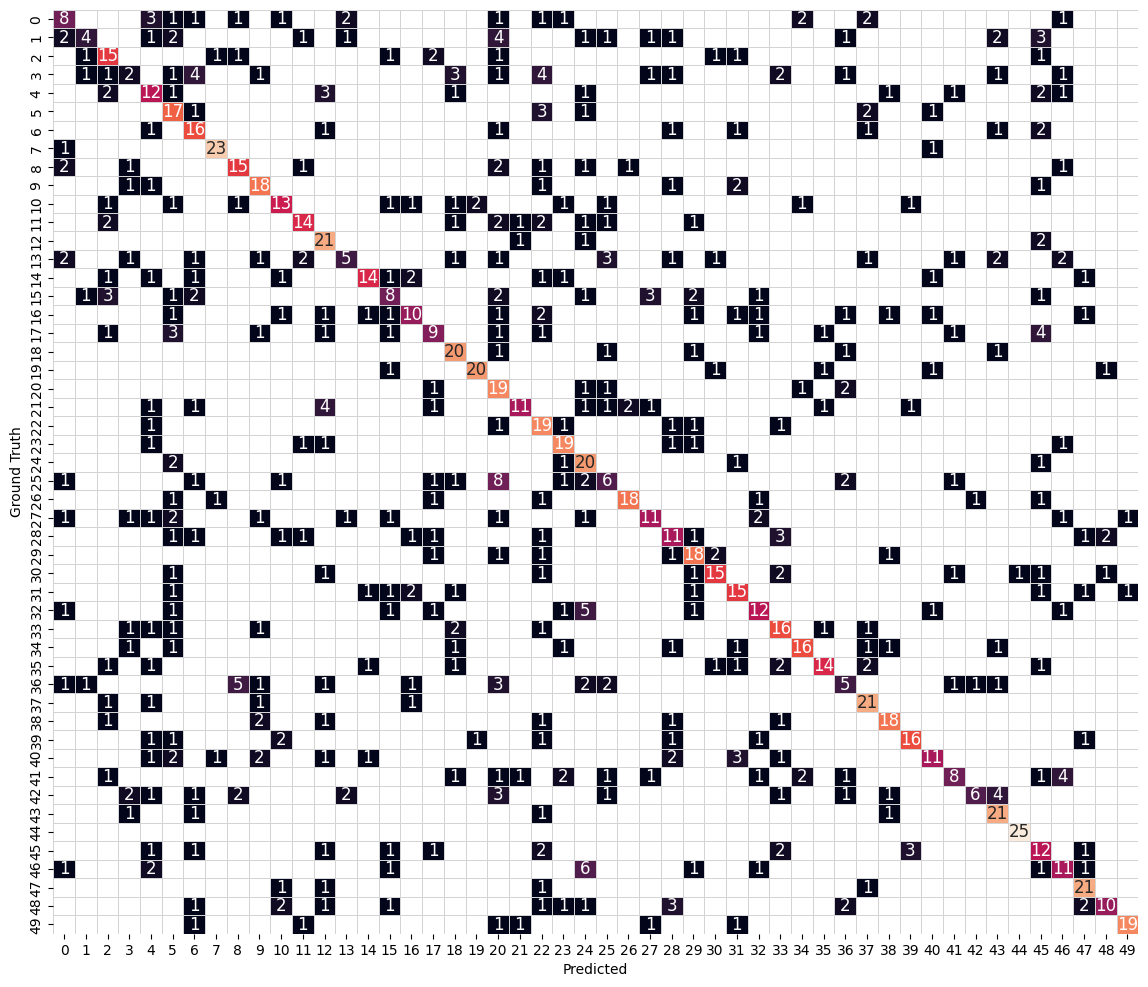

In [25]:
from src.helpers import plot_confusion_matrix

plot_confusion_matrix(pred, truth)